Predicción de la resistencia del concreto usando redes neuronales 
===

* Ultima modificación: 2023-03-11 | [YouTube](https://www.youtube.com/watch?v=2yKOSTeDj8I&list=PLEFpZ3YehTnAGufwvy1LltJoPtjz66CsE&index=7)

* **Contexto.** El concreto es uno de los materiales más usados en construcción. Es fabricado por la mezcla de varios elementos, la cual, al secarse, forma una masa dura muy resistente a la compresión. Uno de los principales problemas es que la mezcla puede demorarse varios meses en secar, y resulta particularmente importante el poder realizar pronósticos de la resistencia que alcanzará, tanto para fines de control como para verificar las restricciones de diseño.

* La muestra contiene 1030 mediciones de concretos con ocho características que decriben los componentes usados en la mezcla. Se piensa que estas ocho características tienen una relación no lineal con la resistencia a la compresión final que tiene el concreto. 

* Se desea construir un modelo de redes neuronales usando las siguientes variables. 

    * Cement (component 1) [Cemento] -- quantitative -- kg in a m3 mixture -- Input Variable 


    * Bla st Furnace Slag [Ceniza] (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable 


    * Fly Ash (component 3) [Ceniza] -- quantitative -- kg in a m3 mixture -- Input Variable 


    * Water (component 4) [Agua] -- quantitative -- kg in a m3 mixture -- Input Variable 


    * Superplasticizer (component 5) [Plastificador] -- quantitative -- kg in a m3 mixture -- Input Variable 


    * Coarse Aggregate (component 6) [Agregado grueso] -- quantitative -- kg in a m3 mixture -- Input Variable 


    * Fine Aggregate (component 7) [Agregado fino] -- quantitative -- kg in a m3 mixture -- Input Variable 


    * Age -- quantitative -- Day (1~365) [Edad] -- Input Variable 


    * Concrete compressive strength [Resistencia a la compresión] -- quantitative -- MPa -- Output Variable 

In [1]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/concrete.csv",
    sep=",",  # separador de campos
    thousands=None,  # separador de miles para números
    decimal=".",
)  # separador de los decimales para números

df.head()

cement   slag  ash  water  superplastic  coarseagg  fineagg  age  strength
0   540.0    0.0  0.0  162.0           2.5     1040.0    676.0   28     79.99
1   540.0    0.0  0.0  162.0           2.5     1055.0    676.0   28     61.89
2   332.5  142.5  0.0  228.0           0.0      932.0    594.0  270     40.27
3   332.5  142.5  0.0  228.0           0.0      932.0    594.0  365     41.05
4   198.6  132.4  0.0  192.0           0.0      978.4    825.5  360     44.30

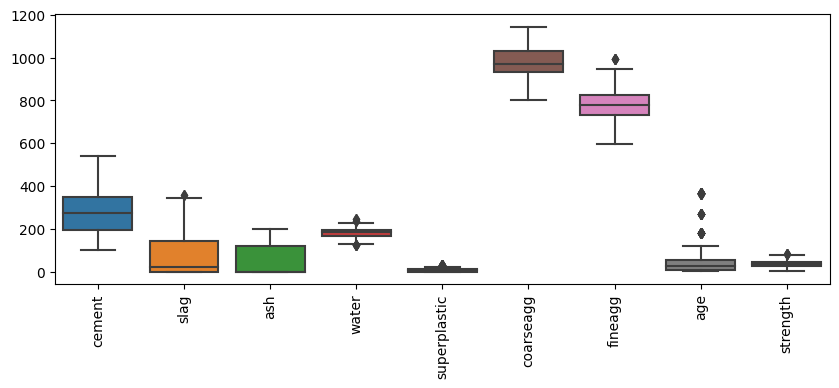

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#
# Los rangos de las variables numéricas son bastantes diferentes
#
plt.figure(figsize=(10, 3.5))
sns.boxplot(data=df)
plt.xticks(rotation=90);

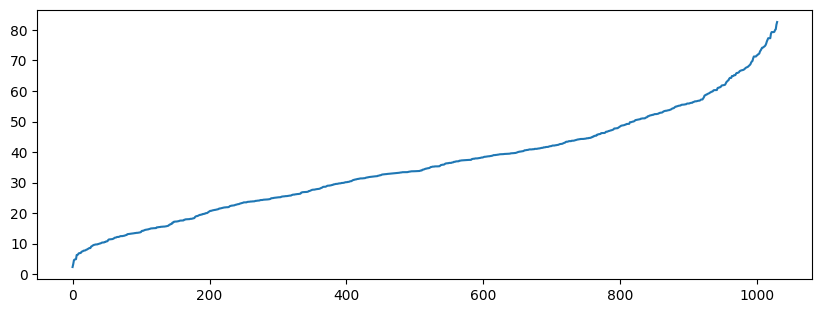

In [3]:
plt.figure(figsize=(10, 3.5))
plt.plot(df.strength.sort_values().to_list())
plt.show()

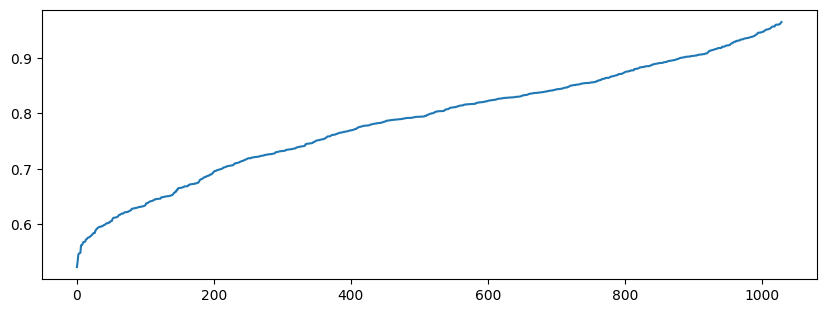

In [4]:
import numpy as np

plt.figure(figsize=(10, 3.5))
plt.plot(
    df.strength.map(lambda y: np.exp(0.04 * y) / (1 + np.exp(0.04 * y)))
    .sort_values()
    .to_list()
)
plt.show()

In [5]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("selectKBest", SelectKBest(score_func=f_regression)),
        ("mlp", MLPRegressor(max_iter=20000, early_stopping=True)),
    ]
)

In [12]:
from sklearn.compose import TransformedTargetRegressor

transformedTargetRegressor = TransformedTargetRegressor(
    regressor=pipeline,
    func=lambda z: np.exp(0.04 * z) / (1 + np.exp(0.04 * z)),
    inverse_func=lambda z: np.log(1 / (1 - z)) / 0.04,
    check_inverse=False,
)

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "regressor__selectKBest__k": [8],
    "regressor__mlp__hidden_layer_sizes": [(i,) for i in range(4, 5)],
    "regressor__mlp__activation": ["logistic", "relu"],
}

gridSearchCV = GridSearchCV(
    estimator=transformedTargetRegressor,
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    refit=True,
)

In [25]:
X = df.copy().drop("strength", axis="columns")
y = df.copy().pop("strength")

In [26]:
X

cement   slag    ash  water  superplastic  coarseagg  fineagg  age
0      540.0    0.0    0.0  162.0           2.5     1040.0    676.0   28
1      540.0    0.0    0.0  162.0           2.5     1055.0    676.0   28
2      332.5  142.5    0.0  228.0           0.0      932.0    594.0  270
3      332.5  142.5    0.0  228.0           0.0      932.0    594.0  365
4      198.6  132.4    0.0  192.0           0.0      978.4    825.5  360
...      ...    ...    ...    ...           ...        ...      ...  ...
1025   276.4  116.0   90.3  179.6           8.9      870.1    768.3   28
1026   322.2    0.0  115.6  196.0          10.4      817.9    813.4   28
1027   148.5  139.4  108.6  192.7           6.1      892.4    780.0   28
1028   159.1  186.7    0.0  175.6          11.3      989.6    788.9   28
1029   260.9  100.5   78.3  200.6           8.6      864.5    761.5   28

[1030 rows x 8 columns]

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [28]:
gridSearchCV.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_function_transformer.py:184: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/compose/_target.py:190: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_function_transformer.py:184: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/compose/_target.py:190: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=

GridSearchCV(cv=10,
             estimator=TransformedTargetRegressor(func=<function <lambda> at 0x7f08d26c4ee0>,
                                                  inverse_func=<function <lambda> at 0x7f08d26c4dc0>,
                                                  regressor=Pipeline(steps=[('scaler',
                                                                             MinMaxScaler()),
                                                                            ('selectKBest',
                                                                             SelectKBest(score_func=<function f_regression at 0x7f08d3a30700>)),
                                                                            ('mlp',
                                                                             MLPRegressor(early_stopping=True,
                                                                                          max_iter=20000))])),
             param_grid={'regressor__mlp__activation': ['logistic', 'relu'],
                         'regressor__mlp__hidden_layer_sizes': [(4,)],
                         'regressor__selectKBest__k': [8]},
             scoring='neg_mean_squared_error')

In [29]:
gridSearchCV.best_params_

{'regressor__mlp__activation': 'logistic',
 'regressor__mlp__hidden_layer_sizes': (4,),
 'regressor__selectKBest__k': 8}

In [30]:
y_train_pred = gridSearchCV.predict(X_train)
y_test_pred = gridSearchCV.predict(X_test)

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

print("Train:")
print(f"  Mean squared error: {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"      Variance score: {r2_score(y_train, y_train_pred):.2f}")
print()
print("Test:")
print(f"  Mean squared error: {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"      Variance score: {r2_score(y_test, y_test_pred):.2f}")

Train:
  Mean squared error: 163.51
      Variance score: 0.41

Test:
  Mean squared error: 184.08
      Variance score: 0.34


In [32]:
import matplotlib.pyplot as plt
import numpy as np


def plot_forecasts(y_true, y_pred):
    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(y_true, y_pred, color="tab:blue", alpha=0.8, edgecolors="white")
    plt.xlabel("y true")
    plt.ylabel("y pred")
    x_ = np.linspace(*plt.gca().get_xlim())
    plt.gca().plot(x_, x_, "k-")
    plt.gca().spines["left"].set_color("gray")
    plt.gca().spines["bottom"].set_color("gray")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.plot()

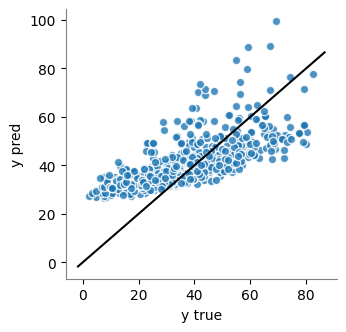

In [33]:
plot_forecasts(y_train, y_train_pred)

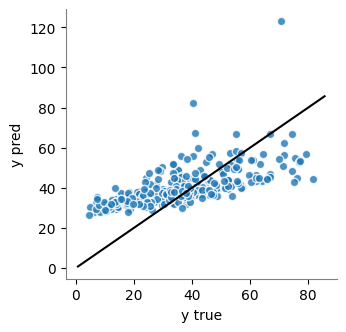

In [34]:
plot_forecasts(y_test, y_test_pred)